## Chapter 3: Classification

### MNIST

In [1]:
# fetch data
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape # Each image is 28x28 pixels, each feature represents intensity from 0 (white) - 255 (black)

(70000, 784)

In [4]:
y.shape

(70000,)

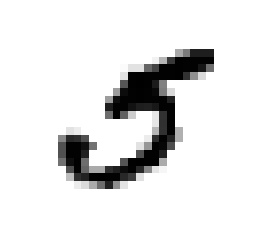

In [5]:
# display an image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]

some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000] # label of the above image

5.0

In [7]:
# MNIST dataset is already split into training set (first 60000) and test set (last 10000)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
#shuffle training set, better distribution of numbers?
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [9]:
# identify digit 5: two classes, 5 and not-5
y_train_5 = (y_train == 5) # boolean array
y_test_5 = (y_test == 5)

In [10]:
# Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
# detect images of number 5
sgd_clf.predict([some_digit])

array([False], dtype=bool)

### Performance Measures

#### Measuring Accuracy Using Cross-Validation

In [12]:
# Implementing Cross-Validation
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96355
0.9678
0.9648


In [13]:
# use cross_val_score with SGDClassifier instead for K-fold cross-validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96355,  0.9678 ,  0.9648 ])

In [14]:
# Compare with baseline - just classify every input as not-5
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90905,  0.91145,  0.90845])

#### Confusion Matrix

In [16]:
# general idea : count the number of times instances of class A classified as class B
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # predictions instead of evaluation score

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)
# each row an actual class, each column a predicted class
# first row negative class (non-5), second row positive class (5)

# true negatives, false positives
# false negatives, true positives

array([[53663,   916],
       [ 1161,  4260]])

In [18]:
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN) (aka sensitivity / true positive rate (TPR))

#### Precision and Recall

In [19]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.82302936630602785

In [20]:
recall_score(y_train_5, y_train_pred)

0.78583287216380737

In [21]:
# F1 score - harmonic mean of precision and recall
# F1 will only be high if both recall and precision high - gives high weight to low values
# F1 = TP / (TP + (FN + FP)/2)

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.80400113239596105

#### Precision/Recall Tradeoff
increasing precision reduces recall and vice versa

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-17816.72995154])

In [23]:
threshold = 0 # default threshold for decision function
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

In [24]:
threshold = 200000 # raise threshold -> may increase precision but decreases recall
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([False], dtype=bool)

In [25]:
# return decision scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
# compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

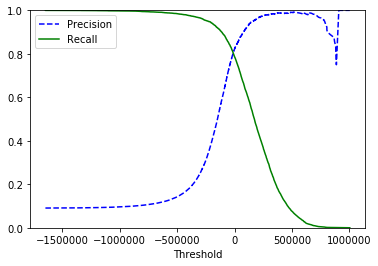

In [27]:
# plot precision and recall as functions of threshold values
def plot_precision_recall_vs_threshold(precisions,recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [28]:
# assume target is 90% precision
y_train_pred_90 = (y_scores > thresholds[np.where(precisions >= 0.9)[0][0]])
precision_score(y_train_5, y_train_pred_90)

0.90027493126718316

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.66445305294226154

#### The ROC Curve
receiver operating characteristic (ROC)
<br>plots true positive rate (TPR) against false positive rate
<br>TPR = recall = ratio of positive instances that are correctly classified as positive
<br>FPR = ratio of positive instances that are incorrectly classified as negative
<br>FPR = 1 - TNR (ratio of negative instances that are correctly classified as negative)
<br>TNR = specificity

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

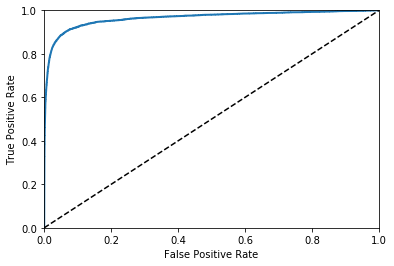

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # ditted line represents ROC curve of a purely random classifier
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
# Measure area under the curve (AUC)
# perfect classifier has AUC of 1
# purely random classifier will have AUC of 0.5
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.96466055531661843

In [33]:
# Compare RandomForestClassifier and SGDClassifier ROC Curves
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba") # return probabilities instead of decision scores
y_scores_forest = y_probas_forest[:, 1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

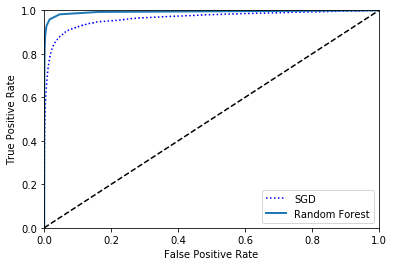

In [34]:
# Compare ROC curves
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [35]:
# ROC AUC for Random Forest Classifier
roc_auc_score(y_train_5, y_scores_forest)

0.99301378907951443

#### Multiclass Classification

one-versus-all (OvA) a.k.a one-versus-the-rest
<br>train 10 binary classifiers (one per digit)
<br>during classification, select the class whose classifier outputs the highest decision score
<br><br>one-versus-one (OvO) strategy
<br>binary classifier for every pair of digits (e.g. 0-1, 0-2 ...)
<br>run image through all classifiers and see which class wins the most duels
<br>disadvantage: O(N^2) classifiers, advantage: each classifier trained on small subset of training set

In [36]:
# Scikit-Learn detects when you try to use binary classifier for multiclass classification
sgd_clf.fit(X_train, y_train) # OvA (except for SVM classifiers which use OvO)
sgd_clf.predict([some_digit])

array([ 5.])

In [37]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores # one score per class

array([[-209235.83641127, -597008.93310426, -406957.47935734,
        -183057.47486546, -258111.00156112,  -17816.72995154,
        -728146.05796114, -298921.39523898, -604934.86187106,
        -568843.99102997]])

In [38]:
np.argmax(some_digit_scores)

5

In [39]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

In [40]:
sgd_clf.classes_[5]

5.0

In [41]:
# force ScikitLearn to use OvO or OvA
from sklearn.multiclass import OneVsOneClassifier # or OneVsRestClassifier (default)
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [42]:
# RandomForestClassifier -> automatically classify instances into multiple classes
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [43]:
forest_clf.predict_proba([some_digit]) # probabilities assigned to each class for instance

array([[ 0. ,  0.1,  0.1,  0. ,  0. ,  0.8,  0. ,  0. ,  0. ,  0. ]])

In [44]:
# Evaluate the classifiers
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.87677465,  0.86034302,  0.85647847])

In [45]:
# scale inputs
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.91086783,  0.91109555,  0.90928639])

#### Error Analysis

In [46]:
# confusion matrix 
# row = actual class
# column = predicted class
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5733,    3,   27,   12,   11,   40,   46,    8,   39,    4],
       [   2, 6493,   47,   21,    5,   50,    6,    9,   97,   12],
       [  56,   34, 5333,  106,   90,   25,   84,   61,  155,   14],
       [  42,   43,  137, 5343,    5,  239,   34,   59,  133,   96],
       [  17,   29,   29,    8, 5391,   12,   48,   22,   83,  203],
       [  71,   38,   34,  183,   86, 4621,  109,   27,  163,   89],
       [  31,   25,   43,    3,   48,   89, 5628,    6,   45,    0],
       [  26,   26,   71,   32,   56,   13,    3, 5794,   15,  229],
       [  50,  160,   70,  149,   14,  171,   56,   25, 5033,  123],
       [  40,   33,   28,   88,  176,   40,    3,  201,   84, 5256]])

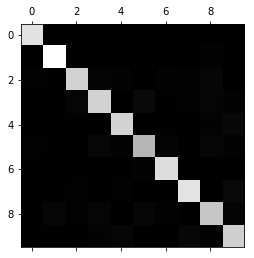

In [47]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

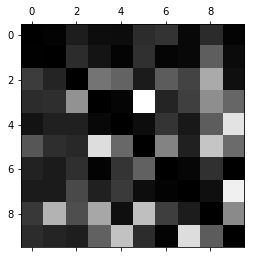

In [48]:
# focus the plot on the errors
row_sums = conf_mx.sum(axis=1, keepdims=True) # normalize to compare error rates
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0) # keep only errors
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [49]:
# brighter boxes indicate higher misclassifications
# columns for 8 and 9 bright -> many classes wrongly predicted as 8 and 9
# perhaps improve classifer for 8 and 9?

#### Multilabel Classfication

In [50]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit]) # large, odd

array([[False,  True]], dtype=bool)

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro") # average F1 score across all labels

#### Multioutput Classification
multilabel classification where each label can be multiclass

In [54]:
# system that removes noise from images
# multilabel - one label per pixel
# multiclass - multiple values (pixel intensity 0-255) per label
from numpy import random as rnd
noise = rnd.randint(0, 100, (len(X_train),784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = y_train
y_test_mod = X_test

In [57]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])

In [58]:
clean_digit

array([ 0.])